In [ ]:
# Train

In [1]:
import os
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from PIL import Image
import numpy as np
import copy

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.normalize(x)
        return x

class DuplicatedCompose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img):
        img1 = img.copy()
        img2 = img.copy()
        for t in self.transforms:
            img1 = t(img1)
            img2 = t(img2)
        return img1, img2

def momentum_update(model_q, model_k, beta = 0.999):
    param_k = model_k.state_dict()
    param_q = model_q.named_parameters()
    for n, q in param_q:
        if n in param_k:
            param_k[n].data.copy_(beta*param_k[n].data + (1-beta)*q.data)
    model_k.load_state_dict(param_k)

def queue_data(data, k):
    return torch.cat([data, k], dim=0)

def dequeue_data(data, K=4096):
    if len(data) > K:
        return data[-K:]
    else:
        return data

def initialize_queue(model_k, device, train_loader):
    queue = torch.zeros((0, 128), dtype=torch.float)
    queue = queue.to(device)

    for batch_idx, (data, target) in enumerate(train_loader):
        x_k = data[1]
        x_k = x_k.to(device)
        k = model_k(x_k)
        k = k.detach()
        queue = queue_data(queue, k)
        queue = dequeue_data(queue, K = 10)
        break
    return queue

def train(model_q, model_k, device, train_loader, queue, optimizer, epoch, temp=0.07):
    model_q.train()
    total_loss = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        x_q = data[0]
        x_k = data[1]

        x_q, x_k = x_q.to(device), x_k.to(device)
        q = model_q(x_q)
        k = model_k(x_k)
        k = k.detach()

        N = data[0].shape[0]
        K = queue.shape[0]
        l_pos = torch.bmm(q.view(N,1,-1), k.view(N,-1,1))
        l_neg = torch.mm(q.view(N,-1), queue.T.view(-1,K))

        logits = torch.cat([l_pos.view(N, 1), l_neg], dim=1)

        labels = torch.zeros(N, dtype=torch.long)
        labels = labels.to(device)

        cross_entropy_loss = nn.CrossEntropyLoss()
        loss = cross_entropy_loss(logits/temp, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        momentum_update(model_q, model_k)

        queue = queue_data(queue, k)
        queue = dequeue_data(queue)

    total_loss /= len(train_loader.dataset)

    print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, total_loss))


batchsize = 100
epochs = 50
out_dir = 'result'

use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 4, 'pin_memory': True}

transform = DuplicatedCompose([
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(28, scale=(0.9, 1.1), ratio=(0.9, 1.1), interpolation=2),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))])

train_mnist = datasets.MNIST('./', train=True, download=True, transform=transform)
test_mnist = datasets.MNIST('./', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_mnist, batch_size=batchsize, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_mnist, batch_size=batchsize, shuffle=True, **kwargs)

model_q = Net().to(device)
model_k = copy.deepcopy(model_q)
optimizer = optim.SGD(model_q.parameters(), lr=0.01, weight_decay=0.0001)

queue = initialize_queue(model_k, device, train_loader)

for epoch in range(1, epochs + 1):
    train(model_q, model_k, device, train_loader, queue, optimizer, epoch)

os.makedirs(out_dir, exist_ok=True)
torch.save(model_q.state_dict(), os.path.join(out_dir, 'model.pth'))

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4589105.86it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 57807.26it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:06<00:00, 242920.01it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 10967489.22it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Train Epoch: 1 	Loss: 0.038213
Train Epoch: 2 	Loss: 0.028767
Train Epoch: 3 	Loss: 0.024028
Train Epoch: 4 	Loss: 0.020525
Train Epoch: 5 	Loss: 0.018022
Train Epoch: 6 	Loss: 0.016153
Train Epoch: 7 	Loss: 0.014726
Train Epoch: 8 	Loss: 0.013678
Train Epoch: 9 	Loss: 0.012844
Train Epoch: 10 	Loss: 0.012307
Train Epoch: 11 	Loss: 0.011715
Train Epoch: 12 	Loss: 0.011372
Train Epoch: 13 	Loss: 0.010921
Train Epoch: 14 	Loss: 0.010607
Train Epoch: 15 	Loss: 0.010226
Train Epoch: 16 	Loss: 0.010033
Train Epoch: 17 	Loss: 0.009797
Train Epoch: 18 	Loss: 0.009547
Train Epoch: 19 	Loss: 0.009349
Train Epoch: 20 	Loss: 0.009124
Train Epoch: 21 	Loss: 0.008993
Train Epoch: 22 	Loss: 0.008870
Train Epoch: 23 	Loss: 0.008650
Train Epoch: 24 	Loss: 0.008547
Train Epoch: 25 	Loss: 0.008331
Train Epoch: 26 	Loss: 0.008188
Train Epoch: 27 	Loss: 0.008133
Train Epoch: 28 	Loss: 0.007970
Train Epoch: 29 	Loss: 0.007839
Train Epoch: 30 

In [2]:
# Test

100%|██████████| 10000/10000 [00:18<00:00, 549.14it/s]


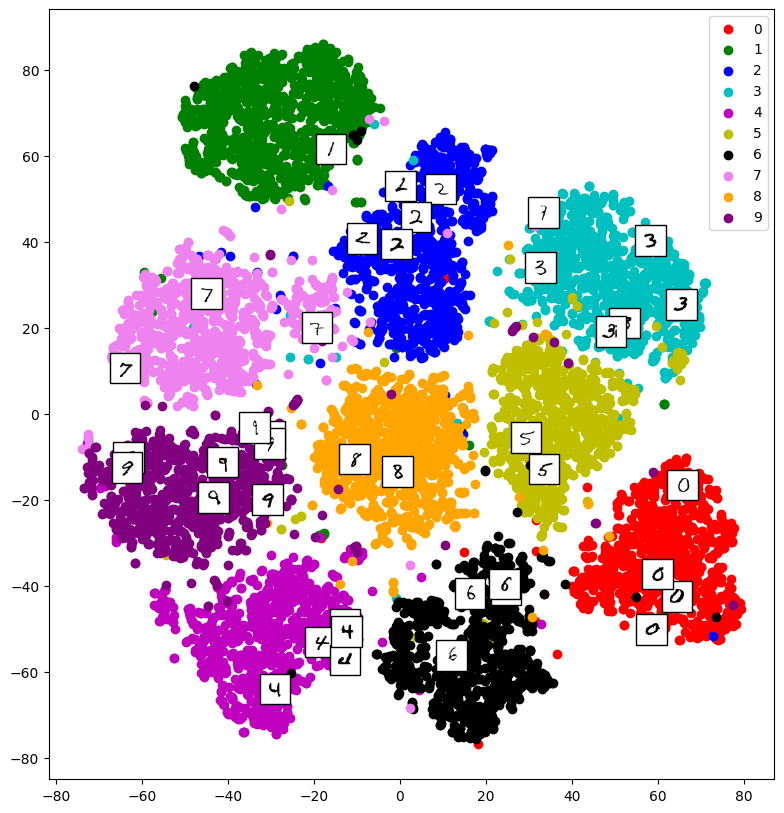

In [7]:
import numpy as np
import tqdm
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


def show(mnist, targets, ret):
    target_ids = range(len(set(targets)))

    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'violet', 'orange', 'purple']

    plt.figure(figsize=(12, 10))

    ax = plt.subplot(aspect='equal')
    for label in set(targets):
        idx = np.where(np.array(targets) == label)[0]
        plt.scatter(ret[idx, 0], ret[idx, 1], c=colors[label], label=label)

    for i in range(0, len(targets), 250):
        img = (mnist[i][0] * 0.3081 + 0.1307).numpy()[0]
        img = OffsetImage(img, cmap=plt.cm.gray_r, zoom=0.5)
        ax.add_artist(AnnotationBbox(img, ret[i]))

    plt.legend()
    plt.show()


model_path = 'result/model.pth'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))])

mnist = datasets.MNIST('./', train=False, download=True, transform=transform)

model = Net()
model.load_state_dict(torch.load(model_path, map_location=torch.device('cuda')))

data = []
targets = []
for m in tqdm.tqdm(mnist):
    target = m[1]
    targets.append(target)
    x = m[0]
    x = x.view(1, *x.shape)
    feat = model(x)
    data.append(feat.data.numpy()[0])

data = np.array(data)
ret = TSNE(n_components=2, random_state=0).fit_transform(data)

show(mnist, targets, ret)